In [1]:
suppressPackageStartupMessages(library(DESeq2))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tibble))

In [2]:
## Perform DESeq2 analysis
doDE <- function(data, meta, ref.level = "OC", design, p.adjust.method = c("fdr", "bonferroni")[1]) {
    ##Build the DDS object
    data_use <- data[, rownames(meta)]
    data_use <- data_use[apply(data_use, 1, max) > 0, ,drop = FALSE] ## Keep the non-zero genes

    dds <- DESeqDataSetFromMatrix(countData = data_use,
                           colData = meta,
                           design= design)
    des_col <- as.character(design)[2] 
    dds[[des_col]] <- relevel(dds[[des_col]], ref = ref.level)
    dds <- DESeq(dds)
    res <- results(dds, pAdjustMethod=p.adjust.method) %>%
            as.data.frame() %>%
            rownames_to_column("gene") %>%
            arrange(padj)
    return(res)
}


load(file = paste0("./load_files/NSC_invitro_dorsal_bulk_RNA.Rdata"))
## subcount, subrpkm, submeta
submeta <- submeta[order(submeta$age, submeta$region, submeta$days), ]
subcount <- subcount[, rownames(submeta)]
subrpkm <- subrpkm[, rownames(submeta)]

In [23]:
subrpkm["DMRT3", 1:18]

RM_1F_42 RM_2F_42 RM_3F_42 RM_4F_42 RM_5F_42 RM_6F_42 RM_7F_42 RM_8F_42 
  0.0113   0.0000   0.0000   0.0000   0.0543   0.1278   0.0667   0.0277 
RM_9F_42 RM_1C_42 RM_2C_42 RM_3C_42 RM_4C_42 RM_5C_42 RM_6C_42 RM_7C_42 
  0.0117   0.2751   0.2283   0.2594   0.2447   0.3248   0.2260   0.3410 
RM_8C_42 RM_9C_42 
  0.1939   0.2246

In [4]:
## Add comparison period (3 periods, early, middle, late)
## here the "days" are "time points"
submeta$period <- sapply(submeta$days, function(x){
    p <- case_when(x <= 3 ~ "early", 
                    x >3 & x < 8 ~ "mid",
                    x >= 8 ~ "late")
    return(p)
    })


deFile <- paste0("./load_files/Bulk_DEseq2_results.rds")
if (!file.exists(deFile)){
    deres <- lapply(c("E42", "E77"), function(ag) {
        prds <- c("early", "mid", "late")
        ag_res <- lapply(prds, function(prd) {
            mm <- submeta[submeta$age %in% ag & submeta$period %in% prd, ]
            data <- subcount[, rownames(mm)]

            all_regs <- c("FC", "OC")
            res <- lapply(all_regs, function(reg) {
                bg_reg <- setdiff(all_regs, reg)

                subres <- doDE(data = data, meta = mm, ref.level = bg_reg, 
                               design = ~ region, p.adjust.method = "fdr") %>%
                            filter((!is.na(log2FoldChange)) & (!is.na(padj))) %>%
                            filter(log2FoldChange >= 1) %>%
                            mutate(padj = p.adjust(pvalue, method = "fdr")) %>%
                            filter(padj <= 0.01) %>% 
                            mutate(age = ag, period = prd, reg.1 = reg, reg.2 = bg_reg)

                ## Add mean/min rpkm values
                test_sps <- rownames(mm)[mm$region %in% reg]
                ref_sps <- rownames(mm)[mm$region %in% bg_reg]
                test_rpkm <- subrpkm[, test_sps, drop = FALSE]
                ref_rpkm <- subrpkm[, ref_sps, drop = FALSE]
                mins <- apply(test_rpkm, 1, min)
                mean.1 <- apply(test_rpkm, 1, mean)
                mean.2 <- apply(ref_rpkm, 1, mean)

                subres$rpkm.min <- mins[as.character(subres$gene)]
                subres$rpkm.mean.1 <- mean.1[as.character(subres$gene)]
                subres$rpkm.mean.2 <- mean.2[as.character(subres$gene)]

                return(subres)
                }) %>%
                do.call(rbind, .)
            return(res)
            }) %>%
            do.call(rbind, .)

        return(ag_res)
        }) %>%
        do.call(rbind, .)
    saveRDS(deres, file = paste0("./load_files/Bulk_DEseq2_results.rds"))
} else {
    deres <- readRDS(file = paste0("./load_files/Bulk_DEseq2_results.rds"))
}

In [26]:
## Extract the DEGs from the DEseq2 analysis
#deres <- readRDS(file = paste0("./load_files/Bulk_DEseq2_results.rds"))
deres %>% filter(gene %in% c("WNT7B", "WNT3A", "WNT8B", "CBLN2", "DMRT3", "DMRTA2")) %>% arrange(gene)

gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,age,period,reg.1,reg.2,rpkm.min,rpkm.mean.1,rpkm.mean.2
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
CBLN2,755.21654,1.135196,0.2125436,5.341003,9.243355e-08,1.951966e-07,E42,late,FC,OC,5.9472,7.6947500,3.939550000
CBLN2,29.19012,2.729872,0.3932999,6.940944,3.894881e-12,3.515444e-11,E77,mid,FC,OC,0.4289,0.5340250,0.078875000
CBLN2,64.12218,3.608471,0.3676077,9.816093,9.599219e-23,2.487798e-21,E77,late,FC,OC,1.0049,1.0275333,0.082033333
DMRT3,10.93757,5.851688,1.3219461,4.426571,9.574297e-06,6.927286e-05,E42,early,OC,FC,0.2283,0.2542667,0.003766667
DMRT3,14.30660,2.147573,0.5989222,3.585729,3.361376e-04,1.545303e-03,E42,mid,OC,FC,0.2260,0.2841250,0.062200000
DMRTA2,2933.77097,1.530215,0.1730654,8.841831,9.416220e-19,6.949170e-17,E42,early,OC,FC,26.8672,30.5171333,9.360266667
WNT3A,21.46365,2.205654,0.5838707,3.777642,1.583205e-04,7.944172e-04,E42,mid,OC,FC,0.3100,0.3873500,0.076525000
WNT7B,232.50486,2.961168,0.3347893,8.844870,9.163466e-19,6.949170e-17,E42,early,OC,FC,1.7004,2.9651000,0.335933333
WNT7B,206.74353,2.357119,0.3576237,6.591058,4.367020e-11,8.217277e-10,E42,mid,OC,FC,1.2109,2.5766000,0.466325000


In [28]:
slim_de <- deres %>%
            filter(rpkm.min >= 0.15 & rpkm.mean.1 >= 0.25)
genelist <- list()
for (ag in c("E42", "E77")){
    for (reg in c("FC", "OC")){
        res <- filter(slim_de, reg.1 %in% reg & age %in% ag)
        sublist <- split(res$gene, res$period)
        names(sublist) <- paste0(ag, "_", reg, "_", names(sublist))
        print(length(sublist))
        genelist <- c(genelist, sublist)
    }
}
saveRDS(genelist, file = paste0("./load_files/Bulk_DEseq2_genes_v2.rds"))

[1] 3
[1] 3
[1] 3
[1] 3


In [30]:
sapply(genelist, function(x) "DMRT3" %in% x) %>% .[. == TRUE]

E42_OC_early   E42_OC_mid 
        TRUE         TRUE

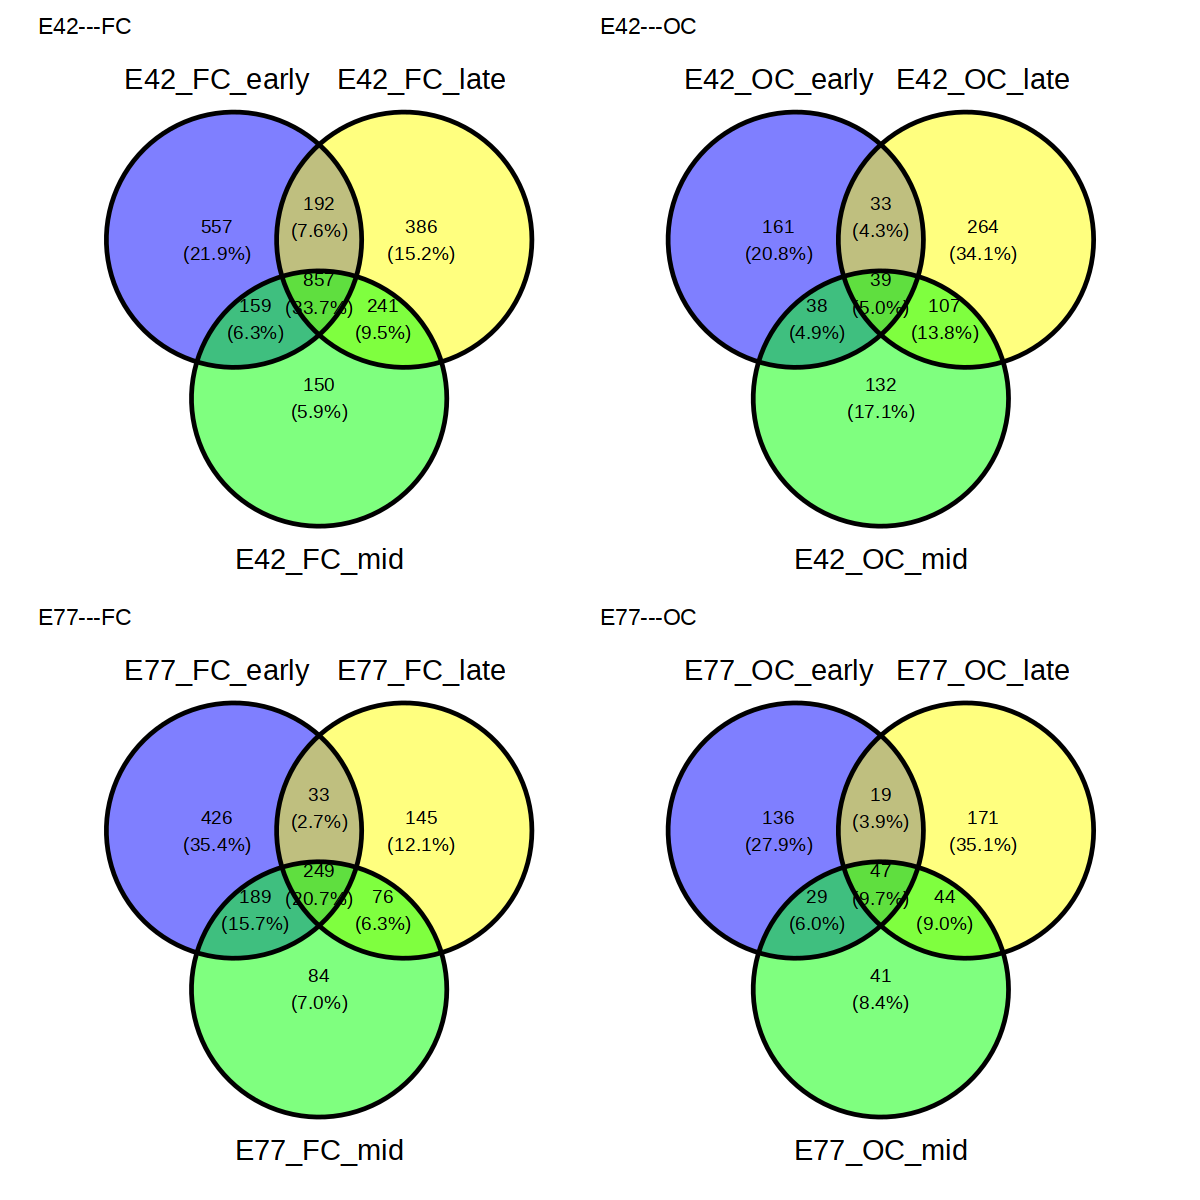

In [31]:
##--------------------------------------------------------------------------
## Venn plot showing the intersections among different DEG sets
genelist <- readRDS(file = paste0("./load_files/Bulk_DEseq2_genes_v2.rds"))

library(ggvenn)
plist <- list()

for (ag in c("E42", "E77")){
    for (reg in c("FC", "OC")){
        sub_sps <- grep(paste0(ag, "_", reg), names(genelist), value = TRUE)
        sublist <- genelist[sub_sps]
        plist[[paste0(ag, "_", reg)]] <- ggvenn(sublist) +
            labs(title = paste0(ag, "---", reg))
    }
}

options(repr.plot.width = 10, repr.plot.height = 10)
p <- patchwork::wrap_plots(plist, nrow = 2, ncol = 2)
p


In [32]:
pdf("./report/DE_overlap_only_vitro_v2.pdf", width = 10, height = 10)
print(p)
dev.off()

png 
  2

In [13]:
sessionInfo()

R version 4.1.0 (2021-05-18)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server 7.9 (Maipo)

Matrix products: default
BLAS:   /gpfs/ycga/home/sm2726/packages/R_versions/R-4.1.0/lib64/R/lib/libRblas.so
LAPACK: /gpfs/ycga/home/sm2726/packages/R_versions/R-4.1.0/lib64/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] ggvenn_0.1.9                ggplot2_3.4.1              
 [3] tibble_3.1.8                dplyr_1.1.0                
 [5] DESeq2_1.34.0               SummarizedEx